# 3. Feature Selection Methods - Adult Income

**Goal:** Reduce dimensionality while preserving predictive power using multiple feature selection techniques.

**Methods Compared:**
1. **Recursive Feature Elimination (RFE)** - Model-based importance
2. **Mutual Information** - Information-theoretic approach
3. **L1 Regularization (Lasso)** - Embedded selection

**Dataset:** UCI Adult Census Income

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    RFE, mutual_info_classif, SelectKBest, SelectFromModel
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load Data
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv('../data/raw/adult.data', names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)
df['target'] = (df['income'] == '>50K').astype(int)

print(f"Dataset shape: {df.shape}")

Dataset shape: (32561, 16)


## 1. Data Preprocessing

Transform categorical and numerical features.

In [2]:
X = df.drop(['income', 'target'], axis=1)
y = df['target']

numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Transformed feature count: {X_train_transformed.shape[1]}")

Transformed feature count: 108


## 2. Baseline Performance (All Features)

In [3]:
rf_baseline = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_transformed, y_train)
baseline_score = rf_baseline.score(X_test_transformed, y_test)
print(f"Baseline Accuracy: {baseline_score:.4f}")

Baseline Accuracy: 0.8589


## 3. Recursive Feature Elimination (RFE)

In [4]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1), 
          n_features_to_select=20, step=5)
rfe.fit(X_train_transformed, y_train)

X_train_rfe = rfe.transform(X_train_transformed)
X_test_rfe = rfe.transform(X_test_transformed)

rf_rfe = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_rfe.fit(X_train_rfe, y_train)
rfe_score = rf_rfe.score(X_test_rfe, y_test)

print(f"RFE Accuracy (Top 20 Features): {rfe_score:.4f}")

RFE Accuracy (Top 20 Features): 0.8537


## 4. Mutual Information

In [5]:
mi = SelectKBest(score_func=mutual_info_classif, k=20)
mi.fit(X_train_transformed, y_train)

X_train_mi = mi.transform(X_train_transformed)
X_test_mi = mi.transform(X_test_transformed)

rf_mi = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_mi.fit(X_train_mi, y_train)
mi_score = rf_mi.score(X_test_mi, y_test)

print(f"Mutual Info Accuracy (Top 20 Features): {mi_score:.4f}")

Mutual Info Accuracy (Top 20 Features): 0.8492


## 5. Comparison

,Method,Features,Accuracy
0,Baseline,108,0.858898
1,RFE,20,0.853677
2,Mutual Info,20,0.849225


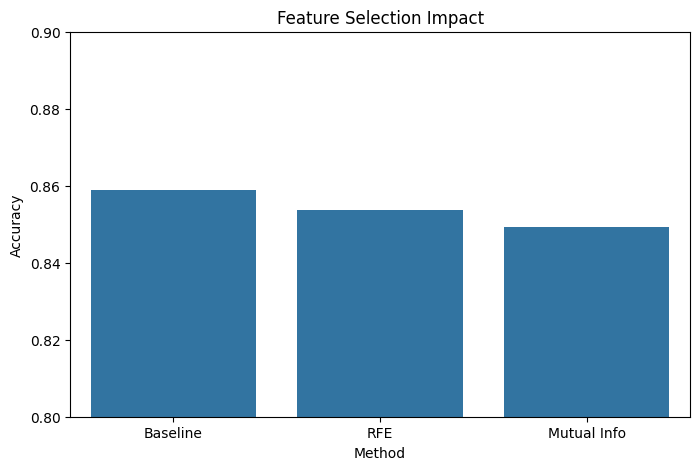

In [6]:
results = pd.DataFrame({
    'Method': ['Baseline', 'RFE', 'Mutual Info'],
    'Features': [X_train_transformed.shape[1], 20, 20],
    'Accuracy': [baseline_score, rfe_score, mi_score]
})
display(results)

plt.figure(figsize=(8, 5))
sns.barplot(x='Method', y='Accuracy', data=results)
plt.ylim(0.8, 0.9)
plt.title('Feature Selection Impact')
plt.show()